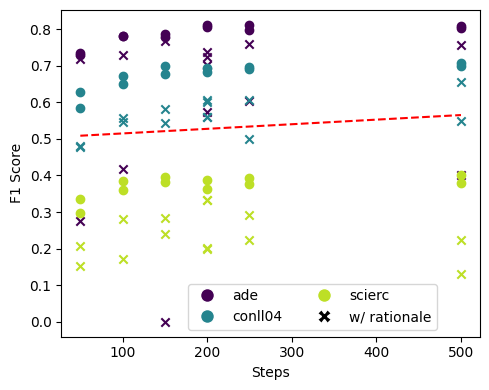

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
results_dir = '../results/test/fine-tuned'

steps = [50, 100, 150, 200, 250, 500]
model_name = 'Mistral-7B-Instruct-v0.3'
f1_dict = {}
dataset_dict = {}
rationale_dict = {}

for step in steps:
    F1_scores = []
    datasets = []
    rationales = []
    for root, dirs, files in os.walk(results_dir):
        for F in files:
            if F.endswith('.json') and model_name in F and f'steps={step}_' in F:
                json_path = os.path.join(root, F)
                with open(json_path, 'r', encoding='utf8') as f:
                    data = json.load(f)
                F1_scores.append(np.mean([line['F1_Score'] for line in data]))
                datasets.append(data[0]['dataset'])
                rationales.append('rationale' in F)
    f1_dict[step] = F1_scores
    dataset_dict[step] = datasets
    rationale_dict[step] = rationales

x = []
y = []
dataset_types = []
rationale_types = []
for k, v_list in f1_dict.items():
    for i, v in enumerate(v_list):
        x.append(k)
        y.append(v)
        dataset_types.append(dataset_dict[k][i])
        rationale_types.append(rationale_dict[k][i])

# Get unique dataset types
unique_datasets = list(set(dataset_types))

# Create a custom colormap that stops before yellow
n_colors = len(unique_datasets)
viridis = plt.get_cmap('viridis')
custom_cmap = ListedColormap(viridis(np.linspace(0, 0.9, n_colors)))
colors = custom_cmap(np.linspace(0, 1, n_colors))

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.figure(figsize=(5, 4))
plt.plot(x, p(x), "r--", label='Trend Line')

# Convert lists to numpy arrays
x = np.array(x)
y = np.array(y)
dataset_types = np.array(dataset_types)
rationale_types = np.array(rationale_types)

# Create a custom colormap that stops before yellow
n_colors = len(unique_datasets)
viridis = plt.get_cmap('viridis')
custom_cmap = ListedColormap(viridis(np.linspace(0, 0.9, n_colors)))
colors = custom_cmap(np.linspace(0, 1, n_colors))

# Plot each dataset with its own color and marker
legend_elements = []
for i, dataset in enumerate(unique_datasets):
    mask = dataset_types == dataset
    rationale_mask = rationale_types[mask]
    
    # Plot points with 'rationale' as crosses (without label)
    plt.scatter(x[mask][rationale_mask], y[mask][rationale_mask], 
                c=[colors[i]], marker='x')
    
    # Plot points without 'rationale' as circles (with label)
    plt.scatter(x[mask][~rationale_mask], y[mask][~rationale_mask], 
                c=[colors[i]], marker='o', label=dataset)
    
    # Add circle marker to legend elements
    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=dataset))

# Add 'X' marker to legend elements
legend_elements.append(Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=10, label='w/ rationale'))

plt.xlabel('Steps')
plt.ylabel('F1 Score')

# Create the legend with custom elements
plt.legend(handles=legend_elements, loc='lower center', ncol=2, bbox_to_anchor=(0.6, 0.00))

plt.tight_layout()
plt.savefig('../paper/f1scores_steps.pdf')
# plt.show()